# Part 1: RNC and DNC Speech Analysis
* The RNC and DNC speeches are written with the intent to persuade an otherwise already persuaded audience.
    * For example, viewers of the RNC are typically republican: "More viewers tuned into Fox News to watch the final night of the Republican convention than any other TV network" (https://www.wsj.com/articles/rnc-ratings-final-night-draws-23-8-million-viewers-as-trump-accepts-nomination-11598652831)
* This analysis will include a classifier which will predict whether a test document is from a republican speaker or a democratic speaker. 
    * Goal: to see if the classifier will be able to recognize differences in the word choices of each group. Hypothesis: high accuracy. Also, see the top features.
* Additionally, I will include a model to see if the length of the speech, the length of the sentences, the TTR, etc. has any significance on predicting between republican and democratic speeches.

## Table of Contents:
* [First Section](#First-Section): importing all needed files and packs
* [Second Section](#Second-Section): using svc classifier to predict R or D with text data
* [Third Section](#Third-Section): testing out logisitic regression with presidential debate
* [Fourth Section](#Fourth-Section): using gridsearch and cv to see the best accuracy with best parameters when certain words are cut out
* [Fifth Section](#Fifth-Section): finding most informative features


### First Section

In [1]:
import pandas as pd
import nltk
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns        # seaborn graphical package
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

In [2]:
conv_speeches = pd.read_csv("/Users/emmatarcson/Documents/data_science/RhetoricalFactor-analysis/data_sample/convspeeches.csv")
conv_speeches = conv_speeches[['Aff','Speech']]
conv_speeches.Aff.value_counts()

R    30
D    21
Name: Aff, dtype: int64

### Second Section

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(conv_speeches['Speech'], conv_speeches['Aff'], random_state=0,
                                  train_size=0.6) 

In [4]:
vectorizer = TfidfVectorizer(min_df=1, max_features=2000, stop_words='english')

X_text_train = vectorizer.fit_transform(X_train)


In [5]:
X_text_test = vectorizer.transform(X_test)

In [6]:
from sklearn.svm import SVC 
svcmodel = SVC(kernel='linear', C=1E5)  
svcmodel.fit(X_text_train, y_train)

SVC(C=100000.0, kernel='linear')

In [7]:
pred = svcmodel.predict(X_text_test)

In [8]:
accuracy_score(y_test, pred)

0.9523809523809523

/Users/emmatarcson/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['D', 'R'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


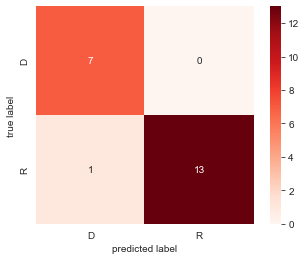

In [9]:
from sklearn.metrics import confusion_matrix
labels = ['D','R']
mat = confusion_matrix(y_test, pred, labels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds",
           xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

* So there is one instance of it guessing Democratic, instead of Republican in the test set. 
* this makes me wonder if there is some super significant word in these speeches that is causing this, but vvv
* That being said, I did expect a higher accuracy from the speeches

### Third Section

In [10]:
import re
trans_toks = [nltk.word_tokenize(re.sub(r'[^\w+ ]', '', t.lower())) for t in conv_speeches['Speech']]
trans_tok_lens = [len(t) for t in trans_toks]
trans_type_lens = [len(set(t)) for t in trans_toks]
TTR = [len(set(t))/len(t) for t in trans_toks]

conv_speeches['Toks'] = trans_toks
conv_speeches['Token_count'] = trans_tok_lens
conv_speeches['Type_count'] = trans_type_lens
conv_speeches['TTR'] = TTR
conv_speeches.head()

,Aff,Speech,Toks,Token_count,Type_count,TTR
0,D,Good evening and thank you to everyone here to...,"[good, evening, and, thank, you, to, everyone,...",193,118,0.611399
1,D,"We climbed the impossible mountain, and right ...","[we, climbed, the, impossible, mountain, and, ...",750,326,0.434667
2,D,"Hello, America. I'm Andrew Yang. You might kno...","[hello, america, im, andrew, yang, you, might,...",428,214,0.500000
3,D,Good evening everybody. As you've seen by now ...,"[good, evening, everybody, as, youve, seen, by...",2278,795,0.348990
4,D,Good evening. Our great nation is now living i...,"[good, evening, our, great, nation, is, now, l...",982,440,0.448065


In [11]:
sents = [len(nltk.sent_tokenize(t)) for t in conv_speeches['Speech']]

conv_speeches['SentAmt'] = sents
conv_speeches['AVGSENTLEN'] = conv_speeches.Token_count/conv_speeches.SentAmt
conv_speeches.head()

,Aff,Speech,Toks,Token_count,Type_count,TTR,SentAmt,AVGSENTLEN
0,D,Good evening and thank you to everyone here to...,"[good, evening, and, thank, you, to, everyone,...",193,118,0.611399,5,38.600000
1,D,"We climbed the impossible mountain, and right ...","[we, climbed, the, impossible, mountain, and, ...",750,326,0.434667,55,13.636364
2,D,"Hello, America. I'm Andrew Yang. You might kno...","[hello, america, im, andrew, yang, you, might,...",428,214,0.500000,25,17.120000
3,D,Good evening everybody. As you've seen by now ...,"[good, evening, everybody, as, youve, seen, by...",2278,795,0.348990,102,22.333333
4,D,Good evening. Our great nation is now living i...,"[good, evening, our, great, nation, is, now, l...",982,440,0.448065,44,22.318182


In [12]:
# building logistic regression
from sklearn.linear_model import LogisticRegression 
X = conv_speeches[['Token_count', 'Type_count', 'TTR', 'SentAmt', 'AVGSENTLEN']]
y = conv_speeches['Aff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)


lr_model = LogisticRegression(C = 1, class_weight= None, penalty='l2')   # default setting
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
accuracy_score(y_test, y_pred) 


0.45454545454545453

Interesting, so for speeches, the svc classifier was almost 100% positive about the Affiliation, but the format of the speeches didn't play a big role. This might actually help my hypothesis in that speeches were more directed at known audience and so they were more polarizing, but the actually makings of the speeches were not as distinguishable.

### Fourth Section

In [13]:
banned = ['Republican', 'Democrat', 'Republicans', 'Democrats']
f = lambda x: ' '.join([item for item in x.split() if item not in banned])
conv_speeches["Speech2"] = conv_speeches["Speech"].apply(f)

In [14]:
conv_speeches.head()

,Aff,Speech,Toks,Token_count,Type_count,TTR,SentAmt,AVGSENTLEN,Speech2
0,D,Good evening and thank you to everyone here to...,"[good, evening, and, thank, you, to, everyone,...",193,118,0.611399,5,38.600000,Good evening and thank you to everyone here to...
1,D,"We climbed the impossible mountain, and right ...","[we, climbed, the, impossible, mountain, and, ...",750,326,0.434667,55,13.636364,"We climbed the impossible mountain, and right ..."
2,D,"Hello, America. I'm Andrew Yang. You might kno...","[hello, america, im, andrew, yang, you, might,...",428,214,0.500000,25,17.120000,"Hello, America. I'm Andrew Yang. You might kno..."
3,D,Good evening everybody. As you've seen by now ...,"[good, evening, everybody, as, youve, seen, by...",2278,795,0.348990,102,22.333333,Good evening everybody. As you've seen by now ...
4,D,Good evening. Our great nation is now living i...,"[good, evening, our, great, nation, is, now, l...",982,440,0.448065,44,22.318182,Good evening. Our great nation is now living i...


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV

x = conv_speeches.Speech2[:1000] 
y = conv_speeches.Aff[:1000]

tfidf_model = TfidfVectorizer()
svc_model = SVC()


pipe = Pipeline(steps=[('tfidf', tfidf_model), ('svc', svc_model)])

param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],        
    'tfidf__stop_words': ['english', None],
    'svc__C': [1E5],
    'svc__kernel' : ['linear'],
    'svc__gamma' : [1]
}                           

search = GridSearchCV(pipe, param_grid, n_jobs=3, cv=5) 
search.fit(x, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=3,
             param_grid={'svc__C': [100000.0], 'svc__gamma': [1],
                         'svc__kernel': ['linear'],
                         'tfidf__max_features': [1000, 2000, 3000],
                         'tfidf__stop_words': ['english', None]})

In [16]:
print('best parameters:', search.best_params_)     # best-performing parameter combo
print('best mean accuracy:', search.best_score_)

best parameters: {'svc__C': 100000.0, 'svc__gamma': 1, 'svc__kernel': 'linear', 'tfidf__max_features': 2000, 'tfidf__stop_words': None}
best mean accuracy: 0.9800000000000001


### Fifth Section

first: trying [tobigue's](https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers) code for an sklearn binary case informative features search:

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(conv_speeches['Speech'], conv_speeches['Aff'], random_state=0,
                                  train_size=0.6)
nbmodel = MultinomialNB()
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2,max_features=1500, stop_words='english') #using this to find vocab
X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)


nbmodel.fit(X_text_train, y_train)
pred = nbmodel.predict(X_text_test)

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

show_most_informative_features(vectorizer, nbmodel)

NameError: name 'MultinomialNB' is not defined

As you can see, it looks a little iffy (especially that left side). Apparently, it's because the nbmodel coefficient concatenates and merges into one array for binary cases. Seen below. 

In [ ]:
nbmodel.coef_

Because of this, I decided to just add in a neutral affiliation with just a "." as the Speech text.

In [ ]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
neutral = pd.DataFrame({'Aff' : 'None', 'Speech': '.'}, index=[1])
conv2 = conv_speeches[['Aff', 'Speech']]
conv2 = pd.concat([conv2, neutral])
conv2.tail()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(conv2['Speech'], conv2['Aff'], random_state=0,
                                  train_size=0.6)
nbmodel = MultinomialNB()
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2,max_features=1500, stop_words='english') #using this to find vocab
X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)


nbmodel.fit(X_text_train, y_train)
pred = nbmodel.predict(X_text_test)

In [ ]:
nbmodel.coef_

As you can see, there are three coefficent lists in the array, which allows me to use the important feature function that uses highest coefficent values.

In [ ]:
def print_top(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[i])[0-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j].replace(' ', '-') for j in top)))
    

print_top(vectorizer, nbmodel, nbmodel.classes_, 60)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(conv_speeches['Speech'], conv_speeches['Aff'], random_state=0,
                                  train_size=0.6)
nbmodel = MultinomialNB()
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2,max_features=1500, stop_words='english') #using this to find vocab
X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)


nbmodel.fit(X_text_train, y_train)
pred = nbmodel.predict(X_text_test)

def print_top2(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[:750])[0-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j].replace(' ', '-') for j in top)))
    

print_top(vectorizer, nbmodel, nbmodel.classes_[0], 60)

In [ ]:
nbmodel.coef_[]

In [ ]:
def print_top2(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[i][:750])[0-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j].replace(' ', '-') for j in top)))
    

print_top(vectorizer, nbmodel, nbmodel.classes_[1], 60)